In [3]:
# https://pypi.org/project/torch-geometric/
# pip install torch
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
# pip install torch-geometric



import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 一、Data Inclusion
<br>
先將 training data include 進來，可以使用 print 看一下 train_data 長甚麼樣子，基本上就是以下這個 format <p>circleID: friend1 friend2 friend3 ... <p/>

總共有57種 features<br>

In [4]:
import os

# Include Training dataset
target_dir = os.getcwd()+"\Training"

data = []
for filename in os.listdir(target_dir):
    with open(os.path.join(target_dir, filename), 'r') as f:
        data += f.readlines()

train_data = []
for i in range(len(data)):
    train_data.append(data[i].split()[1:]) # circle* is seems not nesseary

#print(train_data)
    
    
    
# Total is 57 kinds of features

with open("featureList.txt", 'r') as f:
    feature_list = f.readlines()

for i in range(len(feature_list)):
    feature_list[i] = feature_list[i].replace('\n', '')

#print(feature_list)

最後再 include 每個 Node 對應的 features，並且把它包成 DataFrame，但後續還需要做處理...<br>

In [5]:
# Include each user's features 
    
fea_dir = "features\\features.txt"
features = []

with open(fea_dir, 'r') as f:
    features += f.readlines()

a = [] 

for i in range(len(features)):
    # split each user features by space
    a.append(features[i].split()) 

final = []

# make a dict that key is feature and value is corresponeding value
for j in range(len(a)):
    b_col = []
    b_row = []
    for i in range(len(a[j][1:])):
        b_col.append(a[j][1:][i][::-1].split(';', 1)[1][::-1])
        b_row.append(a[j][1:][i].split(';')[-1])

    final.append(dict(zip(b_col, b_row)))
    
df = pd.DataFrame(final)
#df # there are many NaN

將每個 node 的交友圈 include 進來，並且label每個node

In [6]:
egonets = []
for filename in os.listdir(os.getcwd()+"\egonets"):
    with open(os.path.join(os.getcwd()+"\egonets", filename), 'r') as f:
        egonets += f.readlines()

In [42]:
num_of_user = 238
ego_net = egonets[:num_of_user]

res = []

for ego in ego_net:
    e1, es = ego.split(':')
    es = es.split()

    for e in es:
        res.append((int(e1), int(e)))

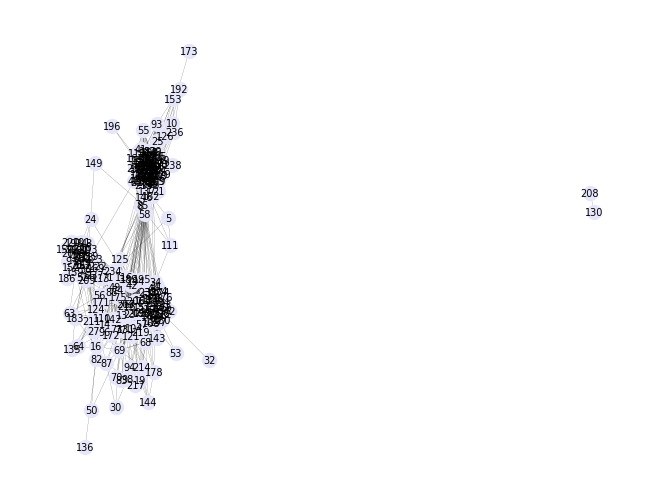

In [39]:
import matplotlib.pyplot as plt
  
# generation of a sample graph
G = nx.Graph()
G.add_edges_from(res)
  
# Defining ego as large and red
# while alters are in lavender
# Let 'A' be the ego
#ego = 1
pos = nx.spring_layout(G)
options = {
            "node_color": "lavender", 
            "node_size": 100,
            "with_labels": True,
            "font_size": 7,
            "width": 0.1,
          }
nx.draw(G, pos, **options)

# ego node below but likely useless in the case
# options = {"node_size": 100, "node_color": "r"}
# nx.draw_networkx_nodes(G, pos, nodelist=[ego], **options)
#plt.figure(figsize=(8, 6), dpi=80)
plt.show()

# 二、Data Preprocessing

之後可以在這裡做一些 feature selection 之類的、或者視覺化<br>
有一些 features 是 NaN，可以做一些處理

# 三、Model

In [4]:
dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)

In [5]:
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)